In [1]:
!pip install transformers datasets
!pip install accelerate

In [2]:
!wget https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2023-08-19 10:38:22--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv.1’

AirlineTweets.csv.1 100%[===================>]   3.26M  4.38MB/s    in 0.7s    

2023-08-19 10:38:23 (4.38 MB/s) - ‘AirlineTweets.csv.1’ saved [3421431/3421431]



In [35]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score,accuracy_score,confusion_matrix

from sklearn.model_selection import train_test_split

In [4]:
df=pd.read_csv('AirlineTweets.csv')

In [5]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
df=df[['airline_sentiment','text']].copy()

In [7]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

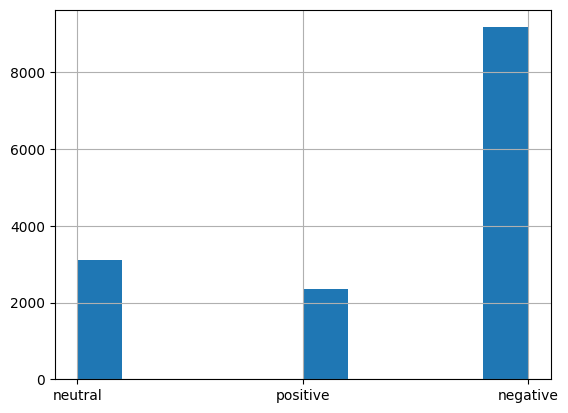

In [8]:
df['airline_sentiment'].hist() #Its imbalance dataset

In [9]:
target_map={'positive':1,'negative':0,'neutral':2}
df['target']=df['airline_sentiment'].map(target_map)

In [10]:
df2=df[['text','target']]
df2.columns=['sentence','label']
df2.to_csv('data.csv',index=None)

In [11]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [12]:
pip install datasets

In [13]:
from datasets import load_dataset
raw_dataset=load_dataset('csv',data_files='data.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [14]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [15]:
split=raw_dataset['train'].train_test_split(test_size=0.3,seed=42)

In [16]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [17]:
# If u have multiple csv files
#load_datasets('csv',data_files=['file1.csv','file2.csv'])

In [18]:
#if we already have train-test split
#load_dataset('csv',
      #data_files={ 'train':['train1.csv','train2.csv']
#                   'test :'test.csv'
#                 }
#    )

In [19]:
checkpoint='distilbert-base-cased'

In [20]:
from transformers import AutoTokenizer

In [21]:
tokenizer=AutoTokenizer.from_pretrained(checkpoint)

In [22]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'],truncation=True) #Trainer will handle padding

In [23]:
tokenized_datasets=split.map(tokenize_fn,batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [24]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4392
    })
})

In [25]:
from transformers import AutoModelForSequenceClassification,Trainer,TrainingArguments

In [26]:
model=AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=3
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
!pip install torchinfo

In [28]:
from torchinfo import summary

In [29]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [30]:
training_args=TrainingArguments(
    output_dir='training_dir',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
)

In [36]:
def compute_metrics(logits_and_labels):
  logits,labels=logits_and_labels
  predictions=np.argmax(logits,axis=-1)
  acc=np.mean(predictions==labels)
  f1=f1_score(labels,predictions,average='macro')
  return {'accuracy':acc,'f1':f1}

In [37]:
trainer=Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [38]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.259000,0.562172,0.820583,0.761280
2,0.216000,0.700406,0.829463,0.770907
3,0.150700,0.818654,0.830829,0.775135


TrainOutput(global_step=1923, training_loss=0.18355550979241317, metrics={'train_runtime': 214.1244, 'train_samples_per_second': 143.58, 'train_steps_per_second': 8.981, 'total_flos': 387616869956304.0, 'train_loss': 0.18355550979241317, 'epoch': 3.0})

In [39]:
!ls training_dir

checkpoint-1282  checkpoint-1923  checkpoint-641  runs


In [40]:
from transformers import pipeline

In [50]:
saved_model=pipeline('text-classification',
                     model='training_dir/checkpoint-641',
                     device=0
                     )

In [51]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [52]:
test_pred=saved_model(split['test']['sentence'])

In [53]:
test_pred

[{'label': 'LABEL_1', 'score': 0.9624465107917786},
 {'label': 'LABEL_1', 'score': 0.9141879677772522},
 {'label': 'LABEL_1', 'score': 0.5697591304779053},
 {'label': 'LABEL_1', 'score': 0.875557541847229},
 {'label': 'LABEL_2', 'score': 0.8810952305793762},
 {'label': 'LABEL_0', 'score': 0.9964666366577148},
 {'label': 'LABEL_2', 'score': 0.8663499355316162},
 {'label': 'LABEL_2', 'score': 0.9427934288978577},
 {'label': 'LABEL_1', 'score': 0.9652352929115295},
 {'label': 'LABEL_0', 'score': 0.9976794123649597},
 {'label': 'LABEL_0', 'score': 0.9893952012062073},
 {'label': 'LABEL_0', 'score': 0.9972731471061707},
 {'label': 'LABEL_1', 'score': 0.9564998745918274},
 {'label': 'LABEL_0', 'score': 0.9868460893630981},
 {'label': 'LABEL_2', 'score': 0.9749209880828857},
 {'label': 'LABEL_1', 'score': 0.58762526512146},
 {'label': 'LABEL_0', 'score': 0.6970254182815552},
 {'label': 'LABEL_0', 'score': 0.9980118274688721},
 {'label': 'LABEL_0', 'score': 0.5638943314552307},
 {'label': 'LAB

In [54]:
def get_label(d):
  return int(d['label'].split("_")[1])

test_pred=[get_label(d) for d in test_pred]

In [55]:
print("Acc:",accuracy_score(split['test']['label'],test_pred))

Acc: 0.8205828779599271


In [56]:
print("f1:",f1_score(split['test']['label'],test_pred,average='macro'))

f1: 0.7612797573795005


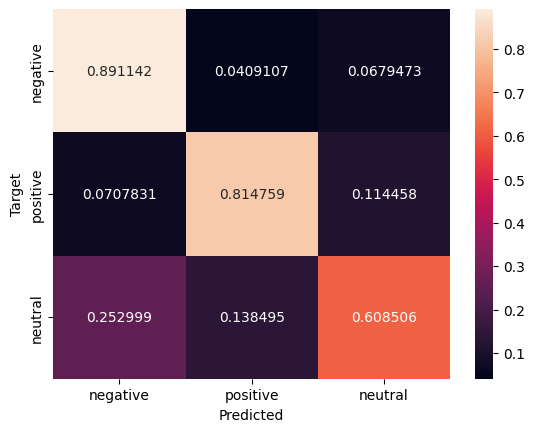

In [62]:
def plot_cm(cm):
  classes=['negative','positive','neutral']
  df_cm=pd.DataFrame(cm,index=classes,columns=classes)
  ax=sn.heatmap(df_cm,annot=True,fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

cm=confusion_matrix(split['test']['label'],test_pred,normalize='true')

plot_cm(cm)